In [3]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.colors import SymLogNorm
import scienceplots

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel
from astropy.cosmology import Planck18,FlatLambdaCDM
from scipy.signal import find_peaks
#from scipy.constants import c


from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import estimate_line_parameters,fit_lines,find_lines_threshold
from specutils.manipulation import extract_region

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb, scipy

from importlib import reload
from spectral_cube import SpectralCube
from reproject import reproject_interp
import regions
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion,RectanglePixelRegion
from regions import PixCoord
sys.path.append('/disk/bifrost/yuanze/KBSS/CubEx_run/scripts')
import run_cubetools_v1 as ctools
#mycosmos=FlatLambdaCDM(H0=70, Om0=0.3)
brightu = r"Brightness $\rm (10^{-4}~erg~s^{-1}~arcsec^{-2}~cm^{-2}~\AA^{-1})$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im
KBSSpath="/disk/bifrost/yuanze/KBSS"

In [116]:
ld=Planck18.luminosity_distance(2.65).to(u.cm).value
print(4*np.pi*ld**2*1e-17)

6.007871259603367e+41


In [153]:
Lya_3arc={}
Lya_v={}
Lya_SB={}
Lya_sigma={}
line_total_flux={}
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN_short_updated.list",format="ipac")
filters = ["table['KCWI'] == 'yes'"]
dtype="KBSS"
all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))
#tid=["Q0100-BX160"]

#id_all=qsos["Name"]

# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
rbin=np.arange(0.3,6.3,0.3)
# windowsize to extract the Lya nebulae
windowsize=6*u.arcsec
#idall=
nondet_list=[]
for nq,sentry in enumerate(tab):
    sourcename=sentry["Name"]#re.findall(r"-(.*)",id)[0]
    csourcename=sentry["CName"]
    field=sentry["Field"]#re.findall(r"(.*)-",id)[0]
    fullname=field+"-"+sourcename
    #sentry=qsos[qsos["Name"]==sourcename]
    #cubename=sentry["Cube"].value[0]
    #ext=sentry["ext"].value[0]
    subdapath=all_directories[nq]#KBSSpath+"/"+field+"/"+sourcename
    datapath=all_data_dir[nq]
    
    Subfile = subdapath+"/{}-{}_icubes.PSFCONTSub.fits".format(field,sourcename)
    varfile=datapath+"/{}-{}_vcubes.fits".format(field,csourcename)
    maskfn=subdapath+"/{}-{}_icubes.PSFSub.mask.fits".format(field,sourcename)
    
    
    O_cube = SpectralCube.read(Subfile)
    OV_cube = SpectralCube.read(varfile)
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"]
    Dec = sentry["Decl"]
#    if sentry["zneb"]>0:
#        redshift=sentry["zneb"]
#    elif sentry["zabs"]>0:
#        redshift=sentry["zabs"]
#    else:
    redshift=sentry["zlya"]
    #redshift=sentry["z_Lyaneb"]
    #sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    pixel_scale=wcsinfo.pixel_scale_matrix[1,1] * 3600

        
    sregion_pix=regions.RectanglePixelRegion(PixCoord(x=sentry['x'],y=sentry['y']),width=windowsize.value/pixel_scale,height=windowsize.value/pixel_scale)
    #sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    #sregion_pix=sregion.to_pixel(wcsinfo)

    #Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    #Var_cube=OV_cube.subcube_from_regions([sregion_pix])
    
    #wcssub=Sub_cube.wcs.celestial
    
    specwidth=1
    cw=1215.67*(1+redshift) * u.AA
    #Lya_varcube = Var_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subvarcube = OV_cube.spectral_slab(cw-10*u.AA,cw+14*u.AA)
    #Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subcube = O_cube.spectral_slab(cw-10*u.AA,cw+14*u.AA)
#    Lya_subcube_wav = Lya_subcube.with_spectral_unit(u.AA, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    
    #Lya_moment_1 = Lya_subcube.moment(order=1)
    #Lya_linewid = Lya_subcube.linewidth_sigma()
    
    #Lya_msig = np.sqrt(Lya_subvarcube.sum(axis=0,how='cube'))
    #Lya_mflux = (Lya_subcube*specwidth).sum(axis=0,how='cube')

    #mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    #Lya_SB[fullname]=Lya_mflux[mask].mean().value*100
    #flux weighted bulk velocity
    #bad=np.isnan(Lya_moment_1[mask])
    #Lya_v[sourcename]=(Lya_moment_1*Lya_mflux)[mask][~bad].sum()/Lya_mflux[mask][~bad].sum()
#    Lya_v[sourcename+"_err"]=np.sqrt((Lya_moment_1*Lya_mflux)[mask][~bad].var())/Lya_mflux[mask][~bad].sum()
    #flux weighted velocity dispersion
    #bad=np.isnan(Lya_linewid[mask])
    #Lya_sigma[sourcename]=(Lya_linewid*Lya_mflux)[mask][~bad].sum()/Lya_mflux[mask][~bad].sum()
#    Lya_sigma[sourcename+"_err"]=np.sqrt((Lya_linewid*Lya_mflux)[mask][~bad].var())/Lya_mflux[mask][~bad].sum()



    # Lya brightness within 3 arcsec
    #region_sky = CircleSkyRegion(center=sc, radius=3 * u.arcsec)
    #region_pix = region_sky.to_pixel(wcssub)
    contmask=fits.open(maskfn)[0].data
    region_pix = CircleAnnulusPixelRegion(PixCoord(x=sentry['x'],y=sentry['y']),0.6/pixel_scale,3/pixel_scale)#CirclePixelRegion(PixCoord(x=sentry['x'],y=sentry['y']), radius=3/pixel_scale)
    camask=region_pix.to_mask()
    camask2D_image = camask.to_image(Lya_subcube.shape[1:])
    mask_2d_filtered=camask2D_image.astype(bool) & (~contmask.astype(bool)) #what if we take the circular-annulus region rather than the CubEx detected region,np.nansum(mask_3d_filtered,axis=0)
    expanded_mask = np.repeat(mask_2d_filtered[np.newaxis, :, :], Lya_subcube.shape[0], axis=0)
    
    
    Lya_mflux_sub=np.nansum(np.where(expanded_mask.astype(bool), Lya_subcube.unmasked_data[:].value, 0),axis=0)
    Lya_mvar_sub=np.nansum(np.where(expanded_mask.astype(bool), Lya_subvarcube.unmasked_data[:].value, 0),axis=0)
    
    #npix=np.sum((~np.isnan(Lya_mflux_sub)).astype(int))
    Lya_3arc[fullname]=[pixel_scale**2*np.nansum(Lya_mflux_sub),pixel_scale**2*np.sqrt(np.nansum(Lya_mvar_sub))]
    print(field,sourcename,"Done")
    print("-----------------------------------------")
    
    ### method 2 =================================================
    Checkcube=fits.open(subdapath+"/{}-{}_icubes.PSFCONTSub.Objects_Id_Lya.fits".format(field,sourcename))
    objcat=np.genfromtxt(subdapath+"/{}-{}_Lya.cat".format(field,sourcename))
    mask_3d=Checkcube[0].data
    
    # wavelength range for the extraction cube
    lw=Checkcube[0].header["CRVAL3"]
    hw=Checkcube[0].header["CRVAL3"]+(mask_3d.shape[0]-1)*Checkcube[0].header["CD3_3"]
    
    #Cut-off: geometric center of the detected object must be within N pixels of the PSF center (1 pix \simeq 0.3 arcsec)
    Npix=15
    s_coord=np.array([sentry['x'],sentry['y']])
    nondet=False
    if len(objcat.shape)>1:
        obj_coord=objcat[:,2:4]
        obj_num=objcat[:,0]
        dis=np.linalg.norm(obj_coord - np.array(s_coord),axis=1)
        print("distance from PSF to objects (pixels):")
        print(dis)
        sel_num=obj_num[dis<Npix]
        print("selected objects: obj_num, N_Voxels")
        print(sel_num,objcat[:,1][dis<Npix])
        if sel_num.size == 0:
            nondet=True
    else:
        sel_num=objcat[0]
        obj_coord=objcat[2:4]
    nondet_list.append(nondet)
    #sel_num=np.array([4])
    #if nondet:
        #region_pixgen = CirclePixelRegion(center=PixCoord(x=sentry['x'],y=sentry['y']),radius=2)
        #mask_3d_filtered = region_pixgen
    mask_3d_filtered=np.isin(mask_3d, sel_num.astype(int))

    region_pix4 = CirclePixelRegion(center=PixCoord(x=sentry['x'],y=sentry['y']),radius=2)
    rmask=region_pix4.to_mask()
    rmask2D_image = rmask.to_image(mask_3d_filtered.shape[1:])
    expanded_rmask_image = np.repeat(rmask2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)
    mask_3d_filtered=mask_3d_filtered & (~expanded_rmask_image.astype(bool))

    mask_2d_filtered=np.nansum(mask_3d_filtered,axis=0)
    subcube1=O_cube.spectral_slab(lw*u.AA,hw*u.AA)
    varsubcube1=OV_cube.spectral_slab(lw*u.AA,hw*u.AA)
    subcube2=subcube1.unmasked_data[:].value
    varsubcube2=varsubcube1.unmasked_data[:].value
    line_maskedcube = np.where(mask_3d_filtered.astype(bool), subcube2, 0)
    line_maskedcube_var = np.where(mask_3d_filtered.astype(bool), varsubcube2, 0)
    line_mflux=np.nansum(line_maskedcube,axis=0)
    line_mflux_var=np.nansum(line_maskedcube_var,axis=0)
                        
    line_total_flux[fullname]=[np.nansum(line_mflux*pixel_scale**2,axis=(0,1)),np.sqrt(np.nansum(line_mflux_var,axis=(0,1)))*pixel_scale**2]
    
    # Log scaled radius SB profile
    """
    Aregions=[]
    Aregions_value=[]
    Aregions_sigvalue=[]
    for rind, rin in enumerate(rbin):
        if rind<len(rbin)-1:
            region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                                inner_radius=rin * u.arcsec,
                                                outer_radius=rbin[rind+1] * u.arcsec)
            region_annulus_pix = region_annulus_sky.to_pixel(wcssub)
            Aregions.append(region_annulus_pix)
            Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_annulus_pix]).sum(axis=0,how='cube')
            Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_annulus_pix]).sum(axis=0,how='cube')
            Aregions_value.append((np.nansum(Lya_mflux_sub/Lya_mvar_sub)/np.nansum(1/Lya_mvar_sub)).value)
            Aregions_sigvalue.append(np.sqrt(1/np.nansum(1/Lya_mvar_sub)).value)
        else:
            continue
    annulus_bin[sourcename]=Aregions
    annulus_value[sourcename]=[Aregions_value,Aregions_sigvalue]
    """
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)







Q0100 BX160 Done
-----------------------------------------
distance from PSF to objects (pixels):
[33.22200024 12.8938939 ]
selected objects: obj_num, N_Voxels
[2.] [98.]


Q0100 BX164 Done
-----------------------------------------
distance from PSF to objects (pixels):
[ 6.11405757 33.71682666 53.10075329 18.20525474 52.67090658 52.54537277]
selected objects: obj_num, N_Voxels
[2.] [343.]


Q0105 BX58 Done
-----------------------------------------


Q0207 D9 Done
-----------------------------------------


Q0256 C31 Done
-----------------------------------------
distance from PSF to objects (pixels):
[28.13699522 28.28718791 28.77148762 28.14889874 28.20244138 28.15324493
 28.13699522  0.25495098 27.94671537 34.71141167]
selected objects: obj_num, N_Voxels
[9.] [188.]


Q0821 RK5 Done
-----------------------------------------


Q1549 BX101 Done
-----------------------------------------
distance from PSF to objects (pixels):
[29.33831113 29.99240237 29.65155139 29.77569814 29.50976279  7.9200505
 29.68006065 29.65051939 29.65258168 29.54347474 28.81297277 30.07064017]
selected objects: obj_num, N_Voxels
[9.] [3713.]


Q1549 MD10 Done
-----------------------------------------
distance from PSF to objects (pixels):
[17.83250964 15.25036393 66.7811388  30.47198221 11.85124466 42.33161466
  5.42108845 28.73676565 33.23038519 41.21173255 54.648247   52.77137955
 15.87288569 25.47734091 42.75565109 10.05940853 13.54057606 47.23218606
 48.41794089 21.57599129 49.08562009 50.20000398 46.69184083 29.63639992
 19.78062183 55.92104166 57.13341667 59.05611738 61.04938984]
selected objects: obj_num, N_Voxels
[ 6.  8. 21. 22.] [835.  86. 139. 105.]


Q1549 MD17 Done
-----------------------------------------
distance from PSF to objects (pixels):
[25.32277433 43.15210771 32.73752129 84.40422857 36.55440466 78.26549751
 42.88704466 24.73778082 21.12280284 34.22106077 51.97578667 38.31252667
 13.79849629 15.79064597 12.12004125 62.58672144 32.98261663 25.21280825
 10.98865324 14.66671402 23.7908743 ]
selected objects: obj_num, N_Voxels
[21. 23. 29. 32.] [ 80.  61.  70. 147.]


Q2233 D5 Done
-----------------------------------------


Q2343 C28 Done
-----------------------------------------
distance from PSF to objects (pixels):
[29.24377712  4.27057373]
selected objects: obj_num, N_Voxels
[2.] [358.]


Q2343 MD77 Done
-----------------------------------------


DSF2237b D1 Done
-----------------------------------------
distance from PSF to objects (pixels):
[ 2.35915239 15.31865856]
selected objects: obj_num, N_Voxels
[1.] [245.]


LyC22 AGN_2223 Done
-----------------------------------------
distance from PSF to objects (pixels):
[36.37139123 36.23109438 35.71702815 35.56391992 35.58736995 35.82828073
 35.57639808 35.57347889  3.08577381  2.64801813 32.44859627 13.46560433]
selected objects: obj_num, N_Voxels
[10. 11. 13.] [56. 88. 53.]


LyC22 M15 Done
-----------------------------------------


In [49]:
Lya_subcube.unmasked_data[:].shape

(25, 100, 100)

In [24]:
import pandas as pd

#col_widths = [12, 5, 10, 10, 10, 18, 12]  # Example widths, adjust as necessary
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"

# Read the data
sedfitted = pd.read_csv("/disk/bifrost/yuanze/KBSS/sedfit_master/summary_csf_all_agegt50.dat", delim_whitespace=True, header=None)
sedfitted.columns = ['ID', 'tau', 'EBV', 'age', 'SFR', 'Mstar', 'chi2nu']
#sedfitted=sedfitted.set_index('ID')
chen2021 = pd.read_csv("/disk/bifrost/yuanze/KBSS/KCWI/sfgs.kcwi", delim_whitespace=True, header=None)
chen2021.columns = ['ID','Lyatot','Lyatoterr']

filtered_sedfit = sedfitted[sedfitted['ID'].isin(chen2021['ID'].to_list())]
#Mstar=filtered_sedfit['Mstar']
merged_set = pd.merge(filtered_sedfit, chen2021, on='ID', how='inner')

allSFGfield=[]
for loc, row in merged_set.iterrows():
    fieldnow=re.findall(r"(.*)-",row["ID"])[0]
    merged_set.at[loc,"field"]=fieldnow
    if fieldnow in allSFGfield:
        continue
    else:
        allSFGfield.append(fieldnow)

for fieldnow in allSFGfield:
    inphot = ascii.read(photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat")
    filterpath = photpath+"/filters_standard."+fieldnow.lower()+".v2"
    all_filters = ascii.read(filterpath)['col1']
    filtind = np.ravel(np.where(all_filters=="Rs_lris"))[0]
    for loc,row in merged_set[merged_set["field"]==fieldnow].iterrows():
        photentry = inphot[inphot['col1']==row["ID"]]
        MRs = photentry["col{}".format(2+2*filtind)][0]
        MRserr = photentry["col{}".format(3+2*filtind)][0]
        merged_set.at[loc,"MRs"]=MRs
        merged_set.at[loc,"MRserr"]=MRserr
        if row["Lyatot"]<2*row["Lyatoterr"]:
            merged_set.at[loc,"Lyatot"]=row["Lyatoterr"]*1

In [57]:
all_filters

Un_lris
G_lris
Rs_lris
mosfire_J
mosfire_H
mosfire_Ks
irac1
irac2
irac3
f140w
f160w


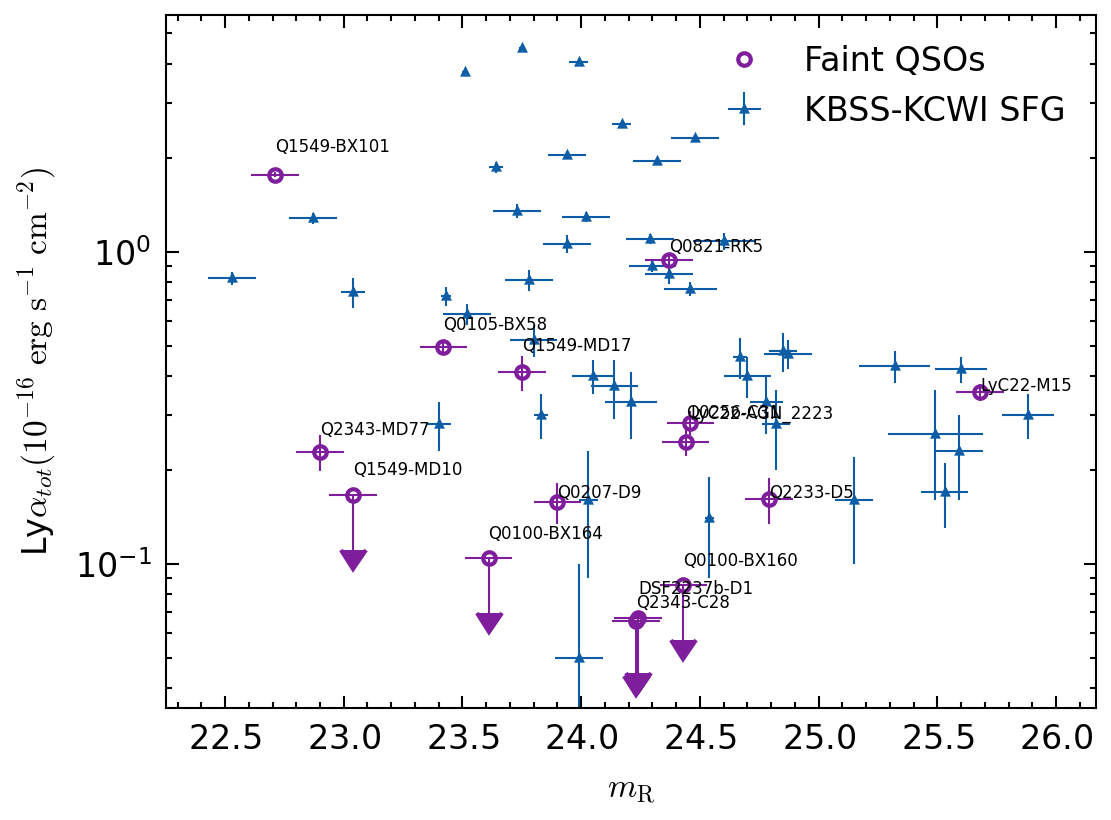

In [154]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

filters = ["table['KCWI'] == 'yes'","table['R'] > 22"]
dtype="KBSS"
source_table = ascii.read(KBSSpath+"/KCWI/KBSS_faint_AGN.list",format="ipac")

all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))

Pub_filt=["sdss.up","sdss.gp","sdss.rp","sdss.ip","sdss.zp","WISE1","WISE2","WISE3","WISE4","2mass.J","2mass.H","2mass.Ks"]

fig,axs=plt.subplots(figsize=(4,3),dpi=300)

axs.errorbar(merged_set["MRs"],merged_set["Lyatot"]*0.1,xerr=merged_set["MRserr"],ms=1,lw=0.5,yerr=merged_set["Lyatoterr"]*0.1,fmt="^",label="KBSS-KCWI SFG")

metrics=Lya_3arc
#metrics2=mstar_2
#metrics1=mstar_1
ms=3
lw=0.5
photpath="/disk/bifrost/yuanze/KBSS/sedfit_master"
tfs=4
Lyatot=[]
Lyatoterr=[]
upper=[]
for ind,sentry in enumerate(tab):
    sourcename=sentry["Name"]
    fieldnow = sentry["Field"]
    fullname=fieldnow+"-"+sourcename
    if sentry["zneb"]>0:
        redshift=sentry["zneb"]
    elif sentry["zabs"]>0:
        redshift=sentry["zabs"]
    else:
        redshift=sentry["zlya"]
    #ld=Planck18.luminosity_distance(redshift).to(u.cm).value
    #S=4*np.pi*ld
    sld=Planck18.luminosity_distance(redshift).to(u.cm).value**2*4*np.pi*1e-16
    print()
    if fullname in Lya_3arc.keys():
        #if sentry["ext"].value[0]=="False":
        #inphot = ascii.read(photpath+"/inphot/"+fieldnow.lower()+"_inphot_refit.dat")
        #filterpath = photpath+"/filters_standard."+fieldnow.lower()+".v2"
        #all_filters = ascii.read(filterpath)['col1']
        #filtind = np.ravel(np.where(all_filters=="Rs_lris"))[0]
        #photentry = inphot[inphot['col1']==fieldnow+"-"+sourcename]
        #MRs = photentry["col{}".format(2+2*filtind)][0]
        mRs = sentry['R']
        mRserr = 0.1#photentry["col{}".format(3+2*filtind)][0]
        uplims=False
        if metrics[fullname][0]<= 3*metrics[fullname][1]:
            uplims=True
            upper.append(1)
            y_toplot = 3*metrics[fullname][1]
            y_tosave = 3*line_total_flux[fullname][1]
            #y_tosave_err = metrics[fullname][1]
        else:
            upper.append(0)
            y_tosave = line_total_flux[fullname][0]
            y_toplot = metrics[fullname][0]
            
        Lyatot.append(y_tosave*sld)
        Lyatoterr.append(line_total_flux[fullname][1]*sld)
        #Lyatot.append(y_toplot*sld)
        #Lyatoterr.append(metrics[fullname][1]*sld)
        axs.errorbar(mRs,y_toplot,xerr=mRserr,yerr=metrics[fullname][1],uplims=uplims,mfc="None",fmt="o",lw=lw,ms=ms,color="xkcd:Purple")
        #else:
        #    axs.errorbar(metrics2[0][ind],metrics[sourcename][0],xerr=metrics2[1][ind],yerr=metrics[sourcename][1],fmt="*",color=colorlst[0])
        jitter=5+np.random.random()
        axs.text(mRs,jitter/5*y_toplot,fullname,fontsize=tfs)#transform=axs.transAxes,verticalalignment='top',horizontalalignment='right',fontsize=7)
#newid1=filtered_id_1.insert(-1,"Q1623-KP76")
from astropy.table import Table, Column
tab.add_column(Column(name='Lyatot', data=Lyatot))
tab.add_column(Column(name='Lyatot_err', data=Lyatoterr))
tab.add_column(Column(name='UpperLim', data=upper))

#qsos_bright.add_column(Column(name='z_Lyaneb', data=z_Lyaneb))
ascii.write(tab,KBSSpath+"/KCWI/KBSS_faint_AGN_short_updated_2.list",format="ipac",overwrite=True)

from matplotlib.lines import Line2D
proxy_line1 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color="xkcd:Purple", label="Faint QSOs")
#proxy_line2 = plt.plot([], [], marker="o",lw=0, mfc="None",ms=ms,color=colorlst[1], label="Type-2 AGN")
axs.legend()
axs.set_xlabel(r"$m_{\rm R}$")
axs.set_ylabel(r"Ly$\alpha_{tot} (10^{-16}~\rm erg~s^{-1}~cm^{-2})$")
#axs.set_xscale
#axs.set_xlim([22,26])

axs.set_yscale("log")

#axs.set_ylim([-1,10])
#axs.set_yticks([1e-2,1e-1,1,5,10])
#axs.set_yticklabels([r"10$^{-2}$",r"10$^{-1}$","1","5","10"])



#axs.set_xscale("symlog")
#fig.savefig(KBSSpath+"/fig/Lya_MRs.pdf")

In [89]:
filters=["table['zlya'] < 2.6","table['zlya'] > 1.","(table['RA'] < 100) | (table['RA'] > 300)","table['KCWI']!='yes'"]
all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))

In [139]:
line_total_flux

{'Q0100-BX160': [0.0, 0.0],
 'Q0100-BX164': [0.24289052, 0.006696460112161477],
 'Q0105-BX58': [0.20659217, 0.006388217870435036],
 'Q0207-D9': [0.12942955, 0.004184911397519613],
 'Q0256-C31': [0.058629822, 0.003458676192873689],
 'Q0821-RK5': [1.4983976, 0.016310792397258002],
 'Q1549-BX101': [2.1973205, 0.023628860937951517],
 'Q1549-GNB4950': [6.7148037, 0.03096382065950382],
 'Q1549-MD10': [0.052294403, 0.004302099224206559],
 'Q1549-MD17': [0.0, 0.0],
 'Q2233-D5': [0.06314069, 0.0041001623269092055],
 'Q2343-C28': [0.13402347, 0.005105463577913021],
 'Q2343-MD77': [0.06467693, 0.004218047328223332],
 'DSF2237b-D1': [0.07627735, 0.0037247010120023054],
 'LyC22-AGN_2223': [0.07663816, 0.003547775648798747],
 'LyC22-M15': [0.22225809, 0.005724994157578589]}

In [93]:
filters=["table['KCWI']=='yes'","table['zlya'] < 2.6","table['zlya'] > 1."]
all_directories,tab,all_data_dir = ctools.find_directories_from_ascii(source_table, KBSSpath,filters=filters,KBSS=(dtype=="KBSS"))

In [128]:
line_total_flux[fullname]

[0.04163807, 0.0033583721927951033]